In [1]:
from os import listdir
from os.path import isfile, join
from collections import namedtuple
from functools import partial
from IPython.display import HTML, display
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)

In [2]:
def dict_inc(d ,key):
    if key in d:
        d[key] += 1
    else:
        d[key] = 1

def get_msg(filename):
    msg = {}
    msg['is_spam'] = "spmsg" in filename
    with open(filename, 'r') as f:
        l = next(f)
        header = []
        for n in l.split()[1:]:
            header.append(int(n))
        msg['header'] = header
        body = []
        for l in f:
            for n in l.split():
                body.append(int(n))
        msg['body'] = body
    return msg  

In [3]:
datapath = "data"
parts = [join(datapath, f) for f in listdir(datapath)]
data = [[get_msg(join(part, f)) for f in listdir(part)] for part in parts]

In [4]:
max_key = 25000
smooth = 1e-20
# for d in data:
#     for msg in d:
#         for word in msg['header']:
#             max_key = max(max_key, word)
#         for word in msg['body']:
#             max_key = max(max_key, word)   
# print(max_key)                              --> got 24747

In [5]:
def convert_msgs(data, converter):
    Xs, Ys = [], []
    for msg in data:
        x, y = converter(msg)
        Xs.append(x)
        Ys.append(y)
    return np.array(Xs), np.array(Ys).astype(int)

def simple_converter(msg):    
    x = np.zeros(max_key, dtype=np.int)
    for word in msg['header']:
        x[word] += 1
    for word in msg['body']:
        x[word] += 1    
    return x, msg['is_spam']

def subject_independent_converter(msg):    
    x = np.zeros(max_key * 2, dtype=np.int)
    for word in msg['header']:
        x[word + max_key] += 1
    for word in msg['body']:
        x[word] += 1    
    return x, msg['is_spam']

def unique_converter(msg):    
    x = np.zeros(max_key, dtype=np.int)
    for word in msg['header']:
        x[word] += 1
    for word in msg['body']:
        x[word] += 10    
    return x, msg['is_spam']

convert_msgs_simple = lambda x: convert_msgs(x, simple_converter)

In [6]:
naive_bayes = namedtuple("naive_bayes", "class_prob prior_prob lambdas")

def fit(X, Y, lambdas=None):
    classes = np.unique(Y)
    class_count = np.max(classes) + 1
    
    prior_prob = np.zeros((class_count, X.shape[1]))
    class_prob = np.zeros(class_count)
    for cl in classes:
        elem_count = Y[Y == cl].shape[0]
        feature_counts = np.sum(X[Y == cl], axis=0)
        all_feature_count = np.sum(feature_counts)

        prior_prob[cl] = (feature_counts + smooth) / (all_feature_count + smooth * X.shape[1])
        class_prob[cl] = float(elem_count) / Y.shape[0]
    
    return naive_bayes(class_prob, prior_prob, lambdas if lambdas != None else np.zeros(class_count))

def predict(bayes, x):
    y_pred = np.zeros(x.shape[0], dtype=np.int)
    for i in np.arange(0, x.shape[0]):
        y_pred[i] = np.argmax(
            bayes.lambdas + np.log(bayes.class_prob) + np.sum(np.log(bayes.prior_prob.T[x[i]>0]), axis=0)
          )
    
    return y_pred

def calc_threshold(bayes, x, y):
    cl_x = x[y == 0]
    min_threshold = 8000
    for i in np.arange(0, cl_x.shape[0]):
        min_threshold = min(min_threshold, 
                            np.log(bayes.class_prob[0]) 
                            - np.log(bayes.class_prob[1]) 
                            + np.sum(np.log(bayes.prior_prob[0][cl_x[i]>0]))
                            - np.sum(np.log(bayes.prior_prob[1][cl_x[i]>0]))
                           )
    return min_threshold

In [7]:
x_parts = []
y_parts = []
for d in data:
    x, y = convert_msgs(d, simple_converter)
    x_parts.append(x)
    y_parts.append(y)
    
x_parts_ind = []
y_parts_ind = []
for d in data:
    x, y = convert_msgs(d, subject_independent_converter)
    x_parts_ind.append(x)
    y_parts_ind.append(y)
    
x_parts_unq = []
y_parts_unq = []
for d in data:
    x, y = convert_msgs(d, unique_converter)
    x_parts_unq.append(x)
    y_parts_unq.append(y)

In [8]:
def precision(contingency_table):
    return contingency_table[1][1] / (contingency_table[1][1] + contingency_table[0][1])

def recall(contingency_table):
    return contingency_table[1][1] / (contingency_table[1][1] + contingency_table[0][0])

def fallout(contingency_table):
    return contingency_table[0][1] / (contingency_table[0][1] + contingency_table[1][0])

def f1_measure(contingency_table):
    p = precision(contingency_table)
    r = recall(contingency_table)
    return 2 * p * r / (p + r)

def cross_validate(x_parts, y_parts, cl=1, params=None):
    contingency_table = [[0,0],[0,0]]
    for i in range(len(x_parts)):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]

        y_pred = predict(fit(x_train, y_train, params), x_test)
        
        true_positive  = np.sum(np.logical_and(y_pred == cl, y_test == cl))
        false_positive = np.sum(np.logical_and(y_pred == cl, y_test != cl))
        true_negative  = np.sum(np.logical_and(y_pred != cl, y_test != cl))
        false_negative = np.sum(np.logical_and(y_pred != cl, y_test == cl))
        
        contingency_table[1][1] += true_positive  / y_test.shape[0] / len(x_parts)
        contingency_table[0][1] += false_positive / y_test.shape[0] / len(x_parts)
        contingency_table[1][0] += true_negative  / y_test.shape[0] / len(x_parts)
        contingency_table[0][0] += false_negative / y_test.shape[0] / len(x_parts)
    
    return contingency_table

def cross_validate_threshold(x_parts, y_parts):
    min_threshold = 8000
    for i in range(len(x_parts)):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]

        min_threshold = min(min_threshold, calc_threshold(fit(x_train, y_train, [0,0]), x_test, y_test))
    return -min_threshold

In [9]:
params = [(l, 0) for l in np.concatenate((
              np.arange(-8000, -1000, 1000),
              np.arange(-1000, +1000, 100),
              np.arange(+1000, +8000, 1000)
))]

In [10]:
contingency_tables = np.array([cross_validate(x_parts_ind, y_parts_ind, 1, p) for p in params])

In [11]:
tpr = [recall(table)     for table in contingency_tables]
fpr = [fallout(table)    for table in contingency_tables]
f1  = [f1_measure(table) for table in contingency_tables]

In [12]:
table = pd.DataFrame(dict(zip([p[0] for p in params],zip(tpr, fpr, f1))))
table['window'] = ['tpr', 'fpr', 'f1']
table.set_index('window', inplace=True)
display(table)

,-8000,-7000,-6000,-5000,-4000,-3000,-2000,-1000,-900,-800,-700,-600,-500,-400,-300,-200,-100,0,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000
window,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tpr,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.997917,0.995833,0.991667,0.981250,0.960417,0.902083,0.837500,0.739583,0.639583,0.5625,0.510417,0.458333,0.414583,0.379167,0.358333,0.193750,0.116667,0.066667,0.050000,0.027083,0.006250
fpr,0.972131,0.959016,0.945902,0.926230,0.868852,0.780328,0.660656,0.444262,0.386885,0.347541,0.319672,0.270492,0.214754,0.175410,0.124590,0.073770,0.026230,0.006557,0.003279,0.001639,0.001639,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f1,0.618158,0.621359,0.624593,0.629508,0.644295,0.668524,0.704329,0.779854,0.802676,0.819113,0.831169,0.853333,0.879927,0.898687,0.924565,0.951049,0.974147,0.975661,0.946448,0.910532,0.849282,0.780178,0.7200,0.675862,0.628571,0.586156,0.549849,0.527607,0.324607,0.208955,0.125000,0.095238,0.052738,0.012422


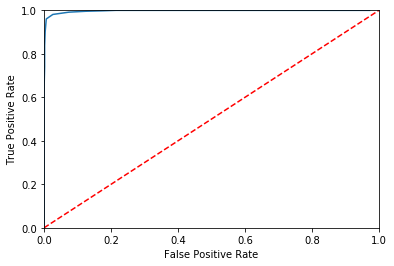

In [13]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

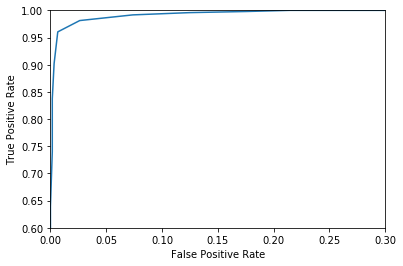

In [14]:
plt.plot(fpr, tpr)
plt.xlim([0, 0.3])
plt.ylim([0.6, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
threshold     = cross_validate_threshold(x_parts, y_parts)
threshold_ind = cross_validate_threshold(x_parts_ind, y_parts_ind)
threshold_unq = cross_validate_threshold(x_parts_unq, y_parts_unq)
print(threshold)
print(threshold_ind)
print(threshold_unq)

397.189445571
348.862323144
416.503238544


In [16]:
f1_m     = f1_measure(cross_validate(x_parts, y_parts, 1, [threshold, 0]))
f1_m_ind = f1_measure(cross_validate(x_parts_ind, y_parts_ind, 1, [threshold_ind, 0]))
f1_m_unq = f1_measure(cross_validate(x_parts_unq, y_parts_unq, 1, [threshold_unq, 0]))
print(f1_m)
print(f1_m_ind)
print(f1_m_unq)

0.740157480315
0.811881188119
0.738501971091


In [17]:
f1_m     = f1_measure(cross_validate(x_parts, y_parts, 1, [0, 0]))
f1_m_ind = f1_measure(cross_validate(x_parts_ind, y_parts_ind, 1, [0, 0]))
f1_m_unq = f1_measure(cross_validate(x_parts_unq, y_parts_unq, 1, [0, 0]))
print(f1_m)
print(f1_m_ind)
print(f1_m_unq)

0.973711882229
0.975661375661
0.974736842105
